In [1]:
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 8)

!date

Sun Apr  7 11:59:07 PDT 2019


# Generation of detailed results table: Large Data

In [2]:
results_dir = '/share/costeffectiveness/results/obesity_custom_observer/2019_04_05_11_15_16'

df = pd.read_hdf(results_dir + '/output.hdf')
df.shape

(20000, 58305)

In [3]:
cause_names = ['ischemic_heart_disease', 'ischemic_stroke', 'diabetes_mellitus_type_2',
               'asthma', 'gout', 'osteoarthritis',
               'chronic_kidney_disease_due_to_hypertension',
               'chronic_kidney_disease_due_to_glomerulonephritis',
               'chronic_kidney_disease_due_to_other_and_unspecified_causes',
               'chronic_kidney_disease_due_to_diabetes_mellitus_type_2',
               'other_causes'
              ]

template_cols = ['cause', 'year', 'sex', 'age_group', 'bmi_group', 'measure', 'scenario', 'input_draw']

years = list(map(lambda x: str(x), np.arange(2020, 2026)))

In [4]:
def clean_and_aggregate(data):
    r = data.copy()
    r.loc[:, 'scenario'] = r['bmi_treatment.treatment_proportion'].map({0: 'baseline', 1: 'treatment'})
    r = r.groupby(['scenario', 'input_draw']).sum()
    return r

In [5]:
%%time

r = clean_and_aggregate(df)

/share/code/abie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


CPU times: user 2min 49s, sys: 40.9 s, total: 3min 30s
Wall time: 3min 30s


In [6]:
def get_year_from_template(template_string):
    return template_string.split('_in_')[1].split('_among')[0]

def get_sex_from_template(template_string):
    return template_string.split('_among_')[1].split('_in')[0].capitalize()

def get_age_group_from_template(template_string):
    return template_string.split('age_group_')[-1].split('_among_bmi_group_')[0]

def get_bmi_group_from_template(template_string):
    return template_string.split('_bmi_group_')[-1]

In [7]:
def standardize_shape(data, measure):
    data = data.filter(like='bmi_group')
    measure_data = data.loc[:, [c for c in r.columns if measure in c]]
    measure_data = (pd.DataFrame(measure_data.stack())
                    .reset_index()
                    .rename(columns={'level_2': 'label', 0: 'value'}))
    if 'due_to' in measure:
        measure, cause = measure.split('_due_to_', 1)
        measure_data.loc[:, 'measure'] = measure
        measure_data.loc[:, 'cause'] = cause
    else:
        measure_data.loc[:, 'measure'] = measure
    measure_data.loc[:, 'year'] = measure_data.label.map(get_year_from_template)
    measure_data.loc[:, 'sex'] = measure_data.label.map(get_sex_from_template)
    measure_data.loc[:, 'age_group'] = measure_data.label.map(get_age_group_from_template)
    measure_data.loc[:, 'bmi_group'] = measure_data.label.map(get_bmi_group_from_template)
    
    measure_data = measure_data.loc[~measure_data.age_group.str.contains('neonatal')]
    measure_data = measure_data.loc[measure_data.age_group.str.split('_').str[0].astype(int) >= 20]
    
    measure_data = measure_data.drop(columns=['label'])
    {}
    return measure_data

In [8]:
# select years in post-intervention period
def get_person_time(data):
    pt = standardize_shape(data, 'person_time')
    pt = pt[pt.year.isin(years)]
    pt = pt.drop(columns='measure').rename(columns={'value': 'person_time'})
    pt = pt.groupby(['sex', 'age_group', 'bmi_group', 'scenario', 'input_draw']).person_time.sum()
    return pt.reset_index()

In [9]:
%%time

person_time = get_person_time(r)

/share/code/abie/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


CPU times: user 1min, sys: 5.66 s, total: 1min 5s
Wall time: 1min 5s


In [10]:
person_time

,sex,age_group,bmi_group,scenario,input_draw,person_time
0,Female,20_to_24,"(0, 27)",baseline,0.0,544.591110
1,Female,20_to_24,"(0, 27)",baseline,1.0,224.147447
2,Female,20_to_24,"(0, 27)",baseline,2.0,1150.527101
3,Female,20_to_24,"(0, 27)",baseline,3.0,949.174880
...,...,...,...,...,...,...
319996,Male,95_plus,"(40, 200)",treatment,996.0,0.000000
319997,Male,95_plus,"(40, 200)",treatment,997.0,8.311797
319998,Male,95_plus,"(40, 200)",treatment,998.0,6.461245
319999,Male,95_plus,"(40, 200)",treatment,999.0,9.049771


In [11]:
def get_disaggregated_results(cause_names):
    #deaths = []
    ylls = []
    ylds = []
    dalys = []
    for cause in cause_names:
        #deaths.append(standardize_shape(r, f'death_due_to_{cause}'))
        ylls_sub = standardize_shape(r, f'ylls_due_to_{cause}')
        ylls.append(ylls_sub)
        if cause != 'other_causes':
            ylds_sub = standardize_shape(r, f'ylds_due_to_{cause}')    
            dalys_sub = (ylds_sub.set_index([c for c in template_cols if c != 'measure']) + \
                         ylls_sub.set_index([c for c in template_cols if c != 'measure'])).reset_index()
            dalys_sub['measure'] = 'dalys'
            
            ylds.append(ylds_sub)
            dalys.append(dalys_sub)
        else: # cause == 'other_causes':
            dalys_sub = (ylls_sub.set_index([c for c in template_cols if c != 'measure'])).reset_index()
            dalys_sub['measure'] = 'dalys'
            dalys.append(dalys_sub)
    
    #death_data = pd.concat(deaths)
    yll_data = pd.concat(ylls)
    yld_data = pd.concat(ylds)
    daly_data = pd.concat(dalys)
    
    output = pd.concat([#death_data,
                        yll_data, yld_data, daly_data])
    output = output.set_index(template_cols).sort_index()
    
    return output.reset_index()

In [12]:
%%time

output = get_disaggregated_results(cause_names)

/share/code/abie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



CPU times: user 55min 26s, sys: 3min 36s, total: 59min 3s
Wall time: 58min 55s


In [13]:
output

,cause,year,sex,age_group,bmi_group,measure,scenario,input_draw,value
0,asthma,2019,Female,20_to_24,"(0, 27)",dalys,baseline,0.0,0.0
1,asthma,2019,Female,20_to_24,"(0, 27)",dalys,baseline,1.0,0.0
2,asthma,2019,Female,20_to_24,"(0, 27)",dalys,baseline,2.0,0.0
3,asthma,2019,Female,20_to_24,"(0, 27)",dalys,baseline,3.0,0.0
...,...,...,...,...,...,...,...,...,...
68479996,other_causes,2025,Male,95_plus,"(40, 200)",ylls,treatment,996.0,0.0
68479997,other_causes,2025,Male,95_plus,"(40, 200)",ylls,treatment,997.0,0.0
68479998,other_causes,2025,Male,95_plus,"(40, 200)",ylls,treatment,998.0,0.0
68479999,other_causes,2025,Male,95_plus,"(40, 200)",ylls,treatment,999.0,0.0


In [14]:
# select post-interventions years then aggregate all years
output_new = output[output.year.isin(years)]
output_new = output_new.groupby([c for c in template_cols if c != 'year']).value.sum().reset_index()

In [15]:
output_new

,cause,sex,age_group,bmi_group,measure,scenario,input_draw,value
0,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,0.0,0.896788
1,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,1.0,0.543508
2,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,2.0,0.937696
3,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,3.0,0.878080
...,...,...,...,...,...,...,...,...
10239996,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,996.0,0.000000
10239997,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,997.0,11.738008
10239998,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,998.0,1.611736
10239999,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,999.0,12.613364


In [16]:
# Aggregate ckd causes at level 4 into ckd parent cause
ckd_names = ['chronic_kidney_disease_due_to_hypertension',
             'chronic_kidney_disease_due_to_glomerulonephritis',
             'chronic_kidney_disease_due_to_diabetes_mellitus_type_2',
             'chronic_kidney_disease_due_to_other_and_unspecified_causes']

def ckd_aggregate(df):
    results = []   
    for name in ckd_names: 
        ckd_sub = df[df.cause == name].drop(columns='cause')
        ckd_sub.set_index(template_cols[2:], inplace=True)
        
        results.append(ckd_sub)
        
    ckd_parent = results[0]  
    for i in range(1, len(results)):
        ckd_parent += results[i]
    
    ckd_parent.reset_index(inplace=True)
    ckd_parent['cause'] = 'chronic_kidney_disease'
    
    return ckd_parent

In [17]:
%%time

ckd_parent = ckd_aggregate(output_new)

CPU times: user 11.7 s, sys: 1.38 s, total: 13.1 s
Wall time: 13 s


In [18]:
ckd_parent

,sex,age_group,bmi_group,measure,scenario,input_draw,value,cause
0,Female,20_to_24,"(0, 27)",dalys,baseline,0.0,0.082346,chronic_kidney_disease
1,Female,20_to_24,"(0, 27)",dalys,baseline,1.0,0.035630,chronic_kidney_disease
2,Female,20_to_24,"(0, 27)",dalys,baseline,2.0,0.605549,chronic_kidney_disease
3,Female,20_to_24,"(0, 27)",dalys,baseline,3.0,0.070468,chronic_kidney_disease
...,...,...,...,...,...,...,...,...
959996,Male,95_plus,"(40, 200)",ylls,treatment,996.0,0.000000,chronic_kidney_disease
959997,Male,95_plus,"(40, 200)",ylls,treatment,997.0,0.000000,chronic_kidney_disease
959998,Male,95_plus,"(40, 200)",ylls,treatment,998.0,0.000000,chronic_kidney_disease
959999,Male,95_plus,"(40, 200)",ylls,treatment,999.0,0.000000,chronic_kidney_disease


In [19]:
# replace ckd sub causes to ckd parent
output_new = output_new[~output_new.cause.isin(ckd_names)].append(ckd_parent)
output_new = output_new.set_index([c for c in template_cols if c != 'year']).sort_index().reset_index()

/share/code/abie/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [20]:
output_new

,cause,sex,age_group,bmi_group,measure,scenario,input_draw,value
0,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,0.0,0.896788
1,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,1.0,0.543508
2,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,2.0,0.937696
3,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,3.0,0.878080
...,...,...,...,...,...,...,...,...
7359996,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,996.0,0.000000
7359997,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,997.0,11.738008
7359998,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,998.0,1.611736
7359999,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,999.0,12.613364


In [21]:
results = pd.merge(output_new, person_time, on=['sex', 'age_group', 'bmi_group', 'scenario', 'input_draw'])

In [22]:
results.set_index([c for c in template_cols if c != 'year']).sort_index().reset_index()

,cause,sex,age_group,bmi_group,measure,scenario,input_draw,value,person_time
0,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,0.0,0.896788,544.591110
1,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,1.0,0.543508,224.147447
2,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,2.0,0.937696,1150.527101
3,asthma,Female,20_to_24,"(0, 27)",dalys,baseline,3.0,0.878080,949.174880
...,...,...,...,...,...,...,...,...,...
7359996,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,996.0,0.000000,0.000000
7359997,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,997.0,11.738008,8.311797
7359998,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,998.0,1.611736,6.461245
7359999,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,999.0,12.613364,9.049771


In [23]:
def append_aggregates(data):
    bmi_aggregate = data.groupby(['cause', 'sex', 'age_group', 'measure', 'scenario', 'input_draw']).sum().reset_index()
    bmi_aggregate['bmi_group'] = '(0, 200)'
    
    data = pd.concat([data, bmi_aggregate], ignore_index=True, sort=True)
    
    age_aggregate = data.groupby(['cause', 'sex', 'bmi_group', 'measure', 'scenario', 'input_draw']).sum().reset_index()
    age_aggregate['age_group'] = '20_plus'

    data = pd.concat([data, age_aggregate], ignore_index=True, sort=True)

    sex_aggregate = data.groupby(['cause', 'age_group', 'bmi_group', 'measure', 'scenario', 'input_draw']).sum().reset_index()
    sex_aggregate['sex'] = 'Both'

    data = pd.concat([data, sex_aggregate], ignore_index=True, sort=True)

    cause_aggregate = data.groupby(['sex', 'age_group', 'bmi_group', 'measure', 'scenario', 'input_draw']).sum().reset_index()
    # person_time should not be summed, though, it is the same for all values in the group
    def unique_val(s):
        assert np.allclose(s, s.mean())
        return float(s.mean())
    
    cause_aggregate['person_time'] = data.groupby(['sex', 'age_group', 'bmi_group',
                                                   'measure', 'scenario', 'input_draw'])\
                                        .person_time.apply(unique_val).reset_index().person_time
    cause_aggregate['cause'] = 'all_causes'
    
    data = pd.concat([data, cause_aggregate], ignore_index=True, sort=True)
    
    return data.set_index([c for c in template_cols if c != 'year']).sort_index().reset_index()

In [24]:
%%time

results_w_agg = append_aggregates(results)

CPU times: user 19min 58s, sys: 34.2 s, total: 20min 33s
Wall time: 20min 32s


In [25]:
# debug

In [26]:
results_w_agg

,cause,sex,age_group,bmi_group,measure,scenario,input_draw,person_time,value
0,all_causes,Both,20_plus,"(0, 200)",dalys,baseline,0.0,484966.694045,146807.028711
1,all_causes,Both,20_plus,"(0, 200)",dalys,baseline,1.0,485486.762491,142949.168368
2,all_causes,Both,20_plus,"(0, 200)",dalys,baseline,2.0,485589.253936,127432.187024
3,all_causes,Both,20_plus,"(0, 200)",dalys,baseline,3.0,485990.732375,125997.146615
...,...,...,...,...,...,...,...,...,...
15911996,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,996.0,0.000000,0.000000
15911997,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,997.0,8.311797,11.738008
15911998,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,998.0,6.461245,1.611736
15911999,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,999.0,9.049771,12.613364


In [27]:
def get_averted_results(df):
    bau = df[df.scenario == 'baseline'].drop(columns=['scenario', 'person_time'])
    t = pd.merge(df, bau, on =[c for c in template_cols if c not in ['year', 'scenario']], suffixes=['', '_bau'])
    t['averted'] = t['value_bau'] - t['value']
    t.drop(columns='value_bau', inplace=True)
    
    return t

In [28]:
%%time

t = get_averted_results(results_w_agg)

CPU times: user 29.1 s, sys: 8.59 s, total: 37.7 s
Wall time: 36 s


In [29]:
t['value'] = (t['value']/t['person_time']) * 100_000
t['averted'] = (t['averted']/t['person_time']) * 100_000

In [30]:
t

,cause,sex,age_group,bmi_group,measure,scenario,input_draw,person_time,value,averted
0,all_causes,Both,20_plus,"(0, 200)",dalys,baseline,0.0,484966.694045,30271.569267,0.000000
1,all_causes,Both,20_plus,"(0, 200)",dalys,treatment,0.0,485011.293634,29945.634767,323.150855
2,all_causes,Both,20_plus,"(0, 200)",dalys,baseline,1.0,485486.762491,29444.503828,0.000000
3,all_causes,Both,20_plus,"(0, 200)",dalys,treatment,1.0,485546.310746,29122.151776,318.740927
...,...,...,...,...,...,...,...,...,...,...
15911996,other_causes,Male,95_plus,"(40, 200)",ylls,baseline,998.0,6.461245,24944.666546,0.000000
15911997,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,998.0,6.461245,24944.666546,0.000000
15911998,other_causes,Male,95_plus,"(40, 200)",ylls,baseline,999.0,9.049771,139377.711299,0.000000
15911999,other_causes,Male,95_plus,"(40, 200)",ylls,treatment,999.0,9.049771,139377.711299,0.000000


In [31]:
%%time

g = t.groupby(list(t.columns[:6]))[['person_time', 'value', 'averted']].describe(percentiles=[.025, .975])

CPU times: user 3min 56s, sys: 6.06 s, total: 4min 3s
Wall time: 4min 3s


In [32]:
table_shell = g.filter([('value', 'mean'), ('value', '2.5%'), ('value', '97.5%'),
                        ('person_time', 'mean'), ('person_time', '2.5%'), ('person_time', '97.5%'),
                        ('averted', 'mean'), ('averted', '2.5%'), ('averted', '97.5%')])

In [33]:
np.round(table_shell, 1)

value           \
                                                             mean     2.5%   
cause        sex  age_group bmi_group measure scenario                       
all_causes   Both 20_plus   (0, 200)  dalys   baseline    26575.0  24839.4   
                                              treatment   26375.5  24685.2   
                                      ylds    baseline     3354.0   2264.5   
                                              treatment    3277.5   2201.9   
...                                                           ...      ...   
other_causes Male 95_plus   (40, 200) dalys   baseline   125713.6      0.0   
                                              treatment  125564.8      0.0   
                                      ylls    baseline   125713.6      0.0   
                                              treatment  125564.8      0.0   

                                                                  person_time  \
                                                            97.5%        mean   
cause        sex  age_group bmi_group measure scenario                          
all_causes   Both 20_plus   (0, 200)  dalys   baseline    29445.1    486153.6   
                                              treatment   29071.0    486190.2   
                                      ylds    baseline     4838.4    486153.6   
                                              treatment    4664.4    486190.2   
...                                                           ...         ...   
other_causes Male 95_plus   (40, 200) dalys   baseline   607700.4        13.4   
                                              treatment  607700.4        13.5   
                                      ylls    baseline   607700.4        13.4   
                                              treatment  607700.4        13.5   

                                                                             \
                                                             2.5%     97.5%   
cause        sex  age_group bmi_group measure scenario                        
all_causes   Both 20_plus   (0, 200)  dalys   baseline   485276.4  486851.3   
                                              treatment  485355.9  486879.7   
                                      ylds    baseline   485276.4  486851.3   
                                              treatment  485355.9  486879.7   
...                                                           ...       ...   
other_causes Male 95_plus   (40, 200) dalys   baseline        0.0      73.4   
                                              treatment       0.0      73.5   
                                      ylls    baseline        0.0      73.4   
                                              treatment       0.0      73.5   

                                                        averted               
                                                           mean  2.5%  97.5%  
cause        sex  age_group bmi_group measure scenario                        
all_causes   Both 20_plus   (0, 200)  dalys   baseline      0.0   0.0    0.0  
                                              treatment   197.5  71.3  452.2  
                                      ylds    baseline      0.0   0.0    0.0  
                                              treatment    76.3  30.6  159.2  
...                                                         ...   ...    ...  
other_causes Male 95_plus   (40, 200) dalys   baseline      0.0   0.0    0.0  
                                              treatment  -214.9   0.0    0.0  
                                      ylls    baseline      0.0   0.0    0.0  
                                              treatment  -214.9   0.0    0.0  

[15912 rows x 9 columns]

In [34]:
(table_shell*np.nan).fillna('')

value             \
                                                         mean 2.5% 97.5%   
cause        sex  age_group bmi_group measure scenario                     
all_causes   Both 20_plus   (0, 200)  dalys   baseline                     
                                              treatment                    
                                      ylds    baseline                     
                                              treatment                    
...                                                       ...  ...   ...   
other_causes Male 95_plus   (40, 200) dalys   baseline                     
                                              treatment                    
                                      ylls    baseline                     
                                              treatment                    

                                                        person_time       \
                                                               mean 2.5%   
cause        sex  age_group bmi_group measure scenario                     
all_causes   Both 20_plus   (0, 200)  dalys   baseline                     
                                              treatment                    
                                      ylds    baseline                     
                                              treatment                    
...                                                             ...  ...   
other_causes Male 95_plus   (40, 200) dalys   baseline                     
                                              treatment                    
                                      ylls    baseline                     
                                              treatment                    

                                                              averted       \
                                                        97.5%    mean 2.5%   
cause        sex  age_group bmi_group measure scenario                       
all_causes   Both 20_plus   (0, 200)  dalys   baseline                       
                                              treatment                      
                                      ylds    baseline                       
                                              treatment                      
...                                                       ...     ...  ...   
other_causes Male 95_plus   (40, 200) dalys   baseline                       
                                              treatment                      
                                      ylls    baseline                       
                                              treatment                      

                                                               
                                                        97.5%  
cause        sex  age_group bmi_group measure scenario         
all_causes   Both 20_plus   (0, 200)  dalys   baseline         
                                              treatment        
                                      ylds    baseline         
                                              treatment        
...                                                       ...  
other_causes Male 95_plus   (40, 200) dalys   baseline         
                                              treatment        
                                      ylls    baseline         
                                              treatment        

[15912 rows x 9 columns]

In [35]:
for col in ['cause', 'sex', 'age_group', 'bmi_group', 'measure', 'scenario']:
    print(col, ':', table_shell.reset_index()[col].unique())
    print()

cause : ['all_causes' 'asthma' 'chronic_kidney_disease' 'diabetes_mellitus_type_2'
 'gout' 'ischemic_heart_disease' 'ischemic_stroke' 'osteoarthritis'
 'other_causes']

sex : ['Both' 'Female' 'Male']

age_group : ['20_plus' '20_to_24' '25_to_29' '30_to_34' '35_to_39' '40_to_44'
 '45_to_49' '50_to_54' '55_to_59' '60_to_64' '65_to_69' '70_to_74'
 '75_to_79' '80_to_84' '85_to_89' '90_to_94' '95_plus']

bmi_group : ['(0, 200)' '(0, 27)' '(27, 30)' '(30, 35)' '(35, 40)' '(40, 200)']

measure : ['dalys' 'ylds' 'ylls']

scenario : ['baseline' 'treatment']



In [36]:
pd.set_option('display.max_rows', 10)
table_shell.query('cause == "osteoarthritis"').head(10)

value  \
                                                                 mean   
cause          sex  age_group bmi_group measure scenario                
osteoarthritis Both 20_plus   (0, 200)  dalys   baseline   521.804676   
                                                treatment  517.448629   
                                        ylds    baseline   521.804676   
                                                treatment  517.448629   
                                        ylls    baseline     0.000000   
                                                treatment    0.000000   
                              (0, 27)   dalys   baseline   495.000267   
                                                treatment  495.000267   
                                        ylds    baseline   495.000267   
                                                treatment  495.000267   

                                                                       \
                                                                 2.5%   
cause          sex  age_group bmi_group measure scenario                
osteoarthritis Both 20_plus   (0, 200)  dalys   baseline   258.191250   
                                                treatment  256.090783   
                                        ylds    baseline   258.191250   
                                                treatment  256.090783   
                                        ylls    baseline     0.000000   
                                                treatment    0.000000   
                              (0, 27)   dalys   baseline   247.405072   
                                                treatment  247.405072   
                                        ylds    baseline   247.405072   
                                                treatment  247.405072   

                                                                        \
                                                                 97.5%   
cause          sex  age_group bmi_group measure scenario                 
osteoarthritis Both 20_plus   (0, 200)  dalys   baseline   1059.754594   
                                                treatment  1050.552118   
                                        ylds    baseline   1059.754594   
                                                treatment  1050.552118   
                                        ylls    baseline      0.000000   
                                                treatment     0.000000   
                              (0, 27)   dalys   baseline   1019.457154   
                                                treatment  1019.457154   
                                        ylds    baseline   1019.457154   
                                                treatment  1019.457154   

                                                             person_time  \
                                                                    mean   
cause          sex  age_group bmi_group measure scenario                   
osteoarthritis Both 20_plus   (0, 200)  dalys   baseline   486153.577317   
                                                treatment  486190.191554   
                                        ylds    baseline   486153.577317   
                                                treatment  486190.191554   
                                        ylls    baseline   486153.577317   
                                                treatment  486190.191554   
                              (0, 27)   dalys   baseline    74586.982341   
                                                treatment   74586.982341   
                                        ylds    baseline    74586.982341   
                                                treatment   74586.982341   

                                                                          \
                                                                    2.5%   
cause          sex  age_group bmi_group measure scenario    

In [37]:
np.round(
    table_shell.query('cause == "osteoarthritis" and sex == "Both" and age_group == "70_to_74"'
                      ' and bmi_group=="(0, 200)"'), 1)

value         \
                                                             mean   2.5%   
cause          sex  age_group bmi_group measure scenario                   
osteoarthritis Both 70_to_74  (0, 200)  dalys   baseline   1223.9  602.0   
                                                treatment  1216.0  596.9   
                                        ylds    baseline   1223.9  602.0   
                                                treatment  1216.0  596.9   
                                        ylls    baseline      0.0    0.0   
                                                treatment     0.0    0.0   

                                                                  person_time  \
                                                            97.5%        mean   
cause          sex  age_group bmi_group measure scenario                        
osteoarthritis Both 70_to_74  (0, 200)  dalys   baseline   2540.8     30490.2   
                                                treatment  2513.7     30494.7   
                                        ylds    baseline   2540.8     30490.2   
                                                treatment  2513.7     30494.7   
                                        ylls    baseline      0.0     30490.2   
                                                treatment     0.0     30494.7   

                                                                             \
                                                              2.5%    97.5%   
cause          sex  age_group bmi_group measure scenario                      
osteoarthritis Both 70_to_74  (0, 200)  dalys   baseline   29918.9  31101.1   
                                                treatment  29926.9  31102.6   
                                        ylds    baseline   29918.9  31101.1   
                                                treatment  29926.9  31102.6   
                                        ylls    baseline   29918.9  31101.1   
                                                treatment  29926.9  31102.6   

                                                          averted             
                                                             mean 2.5% 97.5%  
cause          sex  age_group bmi_group measure scenario                      
osteoarthritis Both 70_to_74  (0, 200)  dalys   baseline      0.0  0.0   0.0  
                                                treatment     7.7  1.9  19.7  
                                        ylds    baseline      0.0  0.0   0.0  
                                                treatment     7.7  1.9  19.7  
                                        ylls    baseline      0.0  0.0   0.0  
                                                treatment     0.0  0.0   0.0

In [38]:
1255.7 - 1221.9

33.799999999999955

In [39]:
cause = 'ischemic_heart_disease'
t = np.round(
    table_shell.query(f'cause == "{cause}" and sex == "Both" and measure == "dalys" and scenario == "treatment"'
                      ' and bmi_group=="(0, 200)"'), 4).loc[:, ('averted', 'mean')]

t.index = ['20_plus', '20_to_24', '25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus']
t

20_plus      95.5963
20_to_24     24.5360
25_to_29     51.2740
30_to_34     52.7464
35_to_39     41.1530
              ...   
75_to_79    155.6267
80_to_84    134.9163
85_to_89    145.4513
90_to_94    232.6592
95_plus     374.3443
Name: (averted, mean), Length: 17, dtype: float64

In [40]:
import matplotlib.pyplot as plt

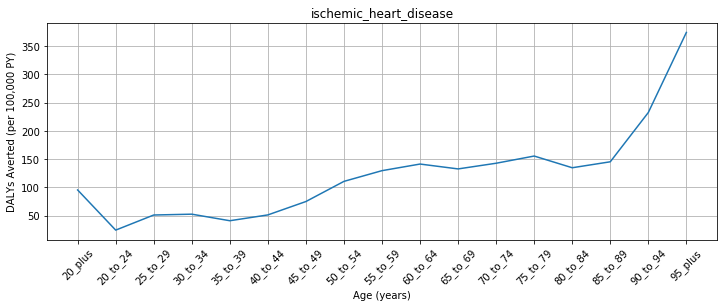

In [41]:
plt.figure(figsize=(12,4))
plt.plot(t.index, t)
plt.ylabel('DALYs Averted (per 100,000 PY)')
plt.xlabel("Age (years)")
plt.grid()
plt.xticks(rotation=45)
plt.title(cause);

In [42]:
np.round(
    table_shell.query('cause == "all_causes" and sex == "Both" and age_group == "20_plus"'
                      ' and bmi_group=="(0, 200)"'), 1)

value           \
                                                          mean     2.5%   
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 200)  dalys   baseline   26575.0  24839.4   
                                            treatment  26375.5  24685.2   
                                    ylds    baseline    3354.0   2264.5   
                                            treatment   3277.5   2201.9   
                                    ylls    baseline   23322.8  22128.3   
                                            treatment  23194.6  22054.7   

                                                               person_time  \
                                                         97.5%        mean   
cause      sex  age_group bmi_group measure scenario                         
all_causes Both 20_plus   (0, 200)  dalys   baseline   29445.1    486153.6   
                                            treatment  29071.0    486190.2   
                                    ylds    baseline    4838.4    486153.6   
                                            treatment   4664.4    486190.2   
                                    ylls    baseline   25234.9    486153.6   
                                            treatment  24960.7    486190.2   

                                                                           \
                                                           2.5%     97.5%   
cause      sex  age_group bmi_group measure scenario                        
all_causes Both 20_plus   (0, 200)  dalys   baseline   485276.4  486851.3   
                                            treatment  485355.9  486879.7   
                                    ylds    baseline   485276.4  486851.3   
                                            treatment  485355.9  486879.7   
                                    ylls    baseline   485276.4  486851.3   
                                            treatment  485355.9  486879.7   

                                                      averted               
                                                         mean  2.5%  97.5%  
cause      sex  age_group bmi_group measure scenario                        
all_causes Both 20_plus   (0, 200)  dalys   baseline      0.0   0.0    0.0  
                                            treatment   197.5  71.3  452.2  
                                    ylds    baseline      0.0   0.0    0.0  
                                            treatment    76.3  30.6  159.2  
                                    ylls    baseline      0.0   0.0    0.0  
                                            treatment   126.4  37.8  313.5

In [43]:
pd.set_option('display.max_rows', 20)
np.round(
    table_shell.query('cause == "all_causes" and sex == "Both" '
                      ' and bmi_group=="(0, 200)" and measure=="ylls" and scenario == "treatment"'), 1)

value           \
                                                          mean     2.5%   
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 200)  ylls    treatment  23194.6  22054.7   
                20_to_24  (0, 200)  ylls    treatment   7513.8   3972.5   
                25_to_29  (0, 200)  ylls    treatment   8096.5   5569.1   
                30_to_34  (0, 200)  ylls    treatment   8289.4   6241.7   
                35_to_39  (0, 200)  ylls    treatment   8920.9   6936.8   
                40_to_44  (0, 200)  ylls    treatment  10358.2   8276.7   
                45_to_49  (0, 200)  ylls    treatment  13555.5  11332.1   
                50_to_54  (0, 200)  ylls    treatment  18794.1  16345.9   
                55_to_59  (0, 200)  ylls    treatment  24440.4  21629.5   
                60_to_64  (0, 200)  ylls    treatment  29808.1  26711.8   
                65_to_69  (0, 200)  ylls    treatment  34483.5  31355.2   
                70_to_74  (0, 200)  ylls    treatment  43377.7  40082.0   
                75_to_79  (0, 200)  ylls    treatment  53143.9  49033.8   
                80_to_84  (0, 200)  ylls    treatment  65731.1  60816.1   
                85_to_89  (0, 200)  ylls    treatment  78746.9  72739.5   
                90_to_94  (0, 200)  ylls    treatment  89905.0  82366.4   
                95_plus   (0, 200)  ylls    treatment  83240.5  74591.2   

                                                               person_time  \
                                                         97.5%        mean   
cause      sex  age_group bmi_group measure scenario                         
all_causes Both 20_plus   (0, 200)  ylls    treatment  24960.7    486190.2   
                20_to_24  (0, 200)  ylls    treatment  14139.2     14362.0   
                25_to_29  (0, 200)  ylls    treatment  12455.1     45420.0   
                30_to_34  (0, 200)  ylls    treatment  10781.0     47044.6   
                35_to_39  (0, 200)  ylls    treatment  11173.7     45137.5   
                40_to_44  (0, 200)  ylls    treatment  12524.2     43000.4   
                45_to_49  (0, 200)  ylls    treatment  16010.5     41475.8   
                50_to_54  (0, 200)  ylls    treatment  21664.5     44025.3   
                55_to_59  (0, 200)  ylls    treatment  27595.1     44990.1   
                60_to_64  (0, 200)  ylls    treatment  33343.1     43856.3   
                65_to_69  (0, 200)  ylls    treatment  37603.8     38244.4   
                70_to_74  (0, 200)  ylls    treatment  46979.1     30494.7   
                75_to_79  (0, 200)  ylls    treatment  57181.5     21152.8   
                80_to_84  (0, 200)  ylls    treatment  70539.1     13394.5   
                85_to_89  (0, 200)  ylls    treatment  84850.1      8055.1   
                90_to_94  (0, 200)  ylls    treatment  97072.2      3973.1   
                95_plus   (0, 200)  ylls    treatment  93023.0      1563.4   

                                                                           \
                                                           2.5%     97.5%   
cause      sex  age_group bmi_group measure scenario                        
all_causes Both 20_plus   (0, 200)  ylls    treatment  485355.9  486879.7   
                20_to_24  (0, 200)  ylls    treatment   13990.7   14732.2   
                25_to_29  (0, 200)  ylls    treatment   44686.0   46112.9   
                30_to_34  (0, 200)  ylls    treatment   46339.0   47730.1   
                35_to_39  (0, 200)  ylls    treatment   44435.6   45831.1   
                40_to_44  (0, 200)  ylls    treatment   42301.3   43699.1   
                45_to_49  (0, 200)  ylls    treatment   40792.8   42126.6   
                50_to_54  (0, 200)  ylls    treatment   43329.4   44715.3   
                55_to_59  (0, 200)  ylls    treatment   44241.8   45714.8   
                60_to_64  (0, 200)  ylls    treatment   43183.3   44496

In [44]:
np.round(
    table_shell.query('cause == "all_causes" and sex == "Both" and age_group == "20_plus"'
                      ' and measure=="dalys" and scenario == "treatment"'), 1)

value           \
                                                          mean     2.5%   
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 200)  dalys   treatment  26375.5  24685.2   
                          (0, 27)   dalys   treatment  27394.0  24805.5   
                          (27, 30)  dalys   treatment  27871.8  25416.4   
                          (30, 35)  dalys   treatment  26384.4  24263.8   
                          (35, 40)  dalys   treatment  24653.2  21506.1   
                          (40, 200) dalys   treatment  24791.1  19413.7   

                                                               person_time  \
                                                         97.5%        mean   
cause      sex  age_group bmi_group measure scenario                         
all_causes Both 20_plus   (0, 200)  dalys   treatment  29071.0    486190.2   
                          (0, 27)   dalys   treatment  29766.4     74587.0   
                          (27, 30)  dalys   treatment  30244.2     76762.6   
                          (30, 35)  dalys   treatment  28593.9    139251.7   
                          (35, 40)  dalys   treatment  27125.7     95926.7   
                          (40, 200) dalys   treatment  31744.2     99662.3   

                                                                           \
                                                           2.5%     97.5%   
cause      sex  age_group bmi_group measure scenario                        
all_causes Both 20_plus   (0, 200)  dalys   treatment  485355.9  486879.7   
                          (0, 27)   dalys   treatment   38526.7  128059.5   
                          (27, 30)  dalys   treatment   38080.3  113466.5   
                          (30, 35)  dalys   treatment   92793.8  157406.1   
                          (35, 40)  dalys   treatment   62662.7  109428.5   
                          (40, 200) dalys   treatment   36157.0  213474.3   

                                                      averted                 
                                                         mean   2.5%   97.5%  
cause      sex  age_group bmi_group measure scenario                          
all_causes Both 20_plus   (0, 200)  dalys   treatment   197.5   71.3   452.2  
                          (0, 27)   dalys   treatment    -0.0   -0.0     0.0  
                          (27, 30)  dalys   treatment     1.4    0.0     3.7  
                          (30, 35)  dalys   treatment   123.4   36.9   238.4  
                          (35, 40)  dalys   treatment   202.8   71.1   390.2  
                          (40, 200) dalys   treatment   555.5  208.0  1023.1

In [45]:
df_for_csu = table_shell.query('cause != "other_causes"')
df_for_csu

value  \
                                                                   mean   
cause          sex  age_group bmi_group measure scenario                  
all_causes     Both 20_plus   (0, 200)  dalys   baseline   26575.008611   
                                                treatment  26375.450898   
                                        ylds    baseline    3354.035384   
                                                treatment   3277.506878   
                                        ylls    baseline   23322.788967   
                                                treatment  23194.580180   
                              (0, 27)   dalys   baseline   27394.042729   
                                                treatment  27394.042729   
                                        ylds    baseline    2851.993672   
                                                treatment   2851.993672   
...                                                                 ...   
osteoarthritis Male 95_plus   (35, 40)  ylds    baseline    1473.969496   
                                                treatment   1468.284761   
                                        ylls    baseline       0.000000   
                                                treatment      0.000000   
                              (40, 200) dalys   baseline    1450.480096   
                                                treatment   1439.946364   
                                        ylds    baseline    1450.480096   
                                                treatment   1439.946364   
                                        ylls    baseline       0.000000   
                                                treatment      0.000000   

                                                                         \
                                                                   2.5%   
cause          sex  age_group bmi_group measure scenario                  
all_causes     Both 20_plus   (0, 200)  dalys   baseline   24839.387028   
                                                treatment  24685.167649   
                                        ylds    baseline    2264.546205   
                                                treatment   2201.893585   
                                        ylls    baseline   22128.260266   
                                                treatment  22054.680835   
                              (0, 27)   dalys   baseline   24805.461145   
                                                treatment  24805.461145   
                                        ylds    baseline    1989.415424   
                                                treatment   1989.415424   
...                                                                 ...   
osteoarthritis Male 95_plus   (35, 40)  ylds    baseline      80.144943   
                                                treatment     63.107845   
                                        ylls    baseline       0.000000   
                                                treatment      0.000000   
                              (40, 200) dalys   baseline       0.000000   
                                                treatment      0.000000   
                                        ylds    baseline       0.000000   
                                                treatment      0.000000   
                                        ylls    baseline       0.000000   
                                                treatment      0.000000   

                                                                         \
                                                                  97.5%   
cause          sex  age_group bmi_group measure scenario                  
all_causes     Both 20_plus   (0, 200)  dalys   baseline   29445.058992   
                                                treatment  29071.004956   
                                        ylds    baseline    4838.446231   
              

In [46]:
col_names = []

for l0, l1 in zip(df_for_csu.columns.get_level_values(0), df_for_csu.columns.get_level_values(1)):
    col_names.append(f'{l0}_{l1}')
col_names

['value_mean',
 'value_2.5%',
 'value_97.5%',
 'person_time_mean',
 'person_time_2.5%',
 'person_time_97.5%',
 'averted_mean',
 'averted_2.5%',
 'averted_97.5%']

In [47]:
df_for_csu.columns = col_names

In [48]:
df_for_csu.reset_index().to_excel(
    '/home/j/Project/simulation_science/cvd/hypothetical_obesity_drug.xlsx',
    index=False,
    engine='xlsxwriter')

In [49]:
np.round(
    df_for_csu.query('cause == "all_causes" and sex == "Both" and age_group == "20_plus"'
                      ' and bmi_group=="(0, 200)" and scenario == "treatment"'), 1)

value_mean  value_2.5%  \
cause      sex  age_group bmi_group measure scenario                            
all_causes Both 20_plus   (0, 200)  dalys   treatment     26375.5     24685.2   
                                    ylds    treatment      3277.5      2201.9   
                                    ylls    treatment     23194.6     22054.7   

                                                       value_97.5%  \
cause      sex  age_group bmi_group measure scenario                 
all_causes Both 20_plus   (0, 200)  dalys   treatment      29071.0   
                                    ylds    treatment       4664.4   
                                    ylls    treatment      24960.7   

                                                       person_time_mean  \
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 200)  dalys   treatment          486190.2   
                                    ylds    treatment          486190.2   
                                    ylls    treatment          486190.2   

                                                       person_time_2.5%  \
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 200)  dalys   treatment          485355.9   
                                    ylds    treatment          485355.9   
                                    ylls    treatment          485355.9   

                                                       person_time_97.5%  \
cause      sex  age_group bmi_group measure scenario                       
all_causes Both 20_plus   (0, 200)  dalys   treatment           486879.7   
                                    ylds    treatment           486879.7   
                                    ylls    treatment           486879.7   

                                                       averted_mean  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 200)  dalys   treatment         197.5   
                                    ylds    treatment          76.3   
                                    ylls    treatment         126.4   

                                                       averted_2.5%  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 200)  dalys   treatment          71.3   
                                    ylds    treatment          30.6   
                                    ylls    treatment          37.8   

                                                       averted_97.5%  
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 200)  dalys   treatment          452.2  
                                    ylds    treatment          159.2  
                                    ylls    treatment          313.5

In [50]:
76.3+126.4

202.7

In [54]:
t = df_for_csu.query('cause == "all_causes" and sex == "Both" and age_group == "20_plus"'
                      ' and measure=="dalys" and scenario == "treatment"')
t = t.iloc[1:]
t

value_mean  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 27)   dalys   treatment  27394.042729   
                          (27, 30)  dalys   treatment  27871.756162   
                          (30, 35)  dalys   treatment  26384.441501   
                          (35, 40)  dalys   treatment  24653.159066   
                          (40, 200) dalys   treatment  24791.080651   

                                                         value_2.5%  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 27)   dalys   treatment  24805.461145   
                          (27, 30)  dalys   treatment  25416.414685   
                          (30, 35)  dalys   treatment  24263.789693   
                          (35, 40)  dalys   treatment  21506.144921   
                          (40, 200) dalys   treatment  19413.673352   

                                                        value_97.5%  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 27)   dalys   treatment  29766.389931   
                          (27, 30)  dalys   treatment  30244.168460   
                          (30, 35)  dalys   treatment  28593.877124   
                          (35, 40)  dalys   treatment  27125.661835   
                          (40, 200) dalys   treatment  31744.248977   

                                                       person_time_mean  \
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 27)   dalys   treatment      74586.982341   
                          (27, 30)  dalys   treatment      76762.583929   
                          (30, 35)  dalys   treatment     139251.662053   
                          (35, 40)  dalys   treatment      95926.660534   
                          (40, 200) dalys   treatment      99662.302697   

                                                       person_time_2.5%  \
cause      sex  age_group bmi_group measure scenario                      
all_causes Both 20_plus   (0, 27)   dalys   treatment      38526.714579   
                          (27, 30)  dalys   treatment      38080.277550   
                          (30, 35)  dalys   treatment      92793.766598   
                          (35, 40)  dalys   treatment      62662.674196   
                          (40, 200) dalys   treatment      36157.031828   

                                                       person_time_97.5%  \
cause      sex  age_group bmi_group measure scenario                       
all_causes Both 20_plus   (0, 27)   dalys   treatment      128059.505133   
                          (27, 30)  dalys   treatment      113466.481520   
                          (30, 35)  dalys   treatment      157406.119439   
                          (35, 40)  dalys   treatment      109428.519849   
                          (40, 200) dalys   treatment      213474.295346   

                                                       averted_mean  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 27)   dalys   treatment -5.041753e-15   
                          (27, 30)  dalys   treatment  1.354909e+00   
                          (30, 35)  dalys   treatment  1.234002e+02   
                          (35, 40)  dalys   treatment  2.027631e+02   
                          (40, 200) dalys   treatment  5.554952e+02   

                                                       averted_2.5%  \
cause      sex  age_group bmi_group measure scenario                  
all_causes Both 20_plus   (0, 27)   dalys   treatment -4.680325e-12   
                          (27, 30)  dalys   treatment  0.000000e+00   
                          (30, 35)  dalys   treatment  3.690796e+01   
                          (35, 40)  dalys   treatment  7.107199e+01   
                          (40, 200) dalys   treatment 

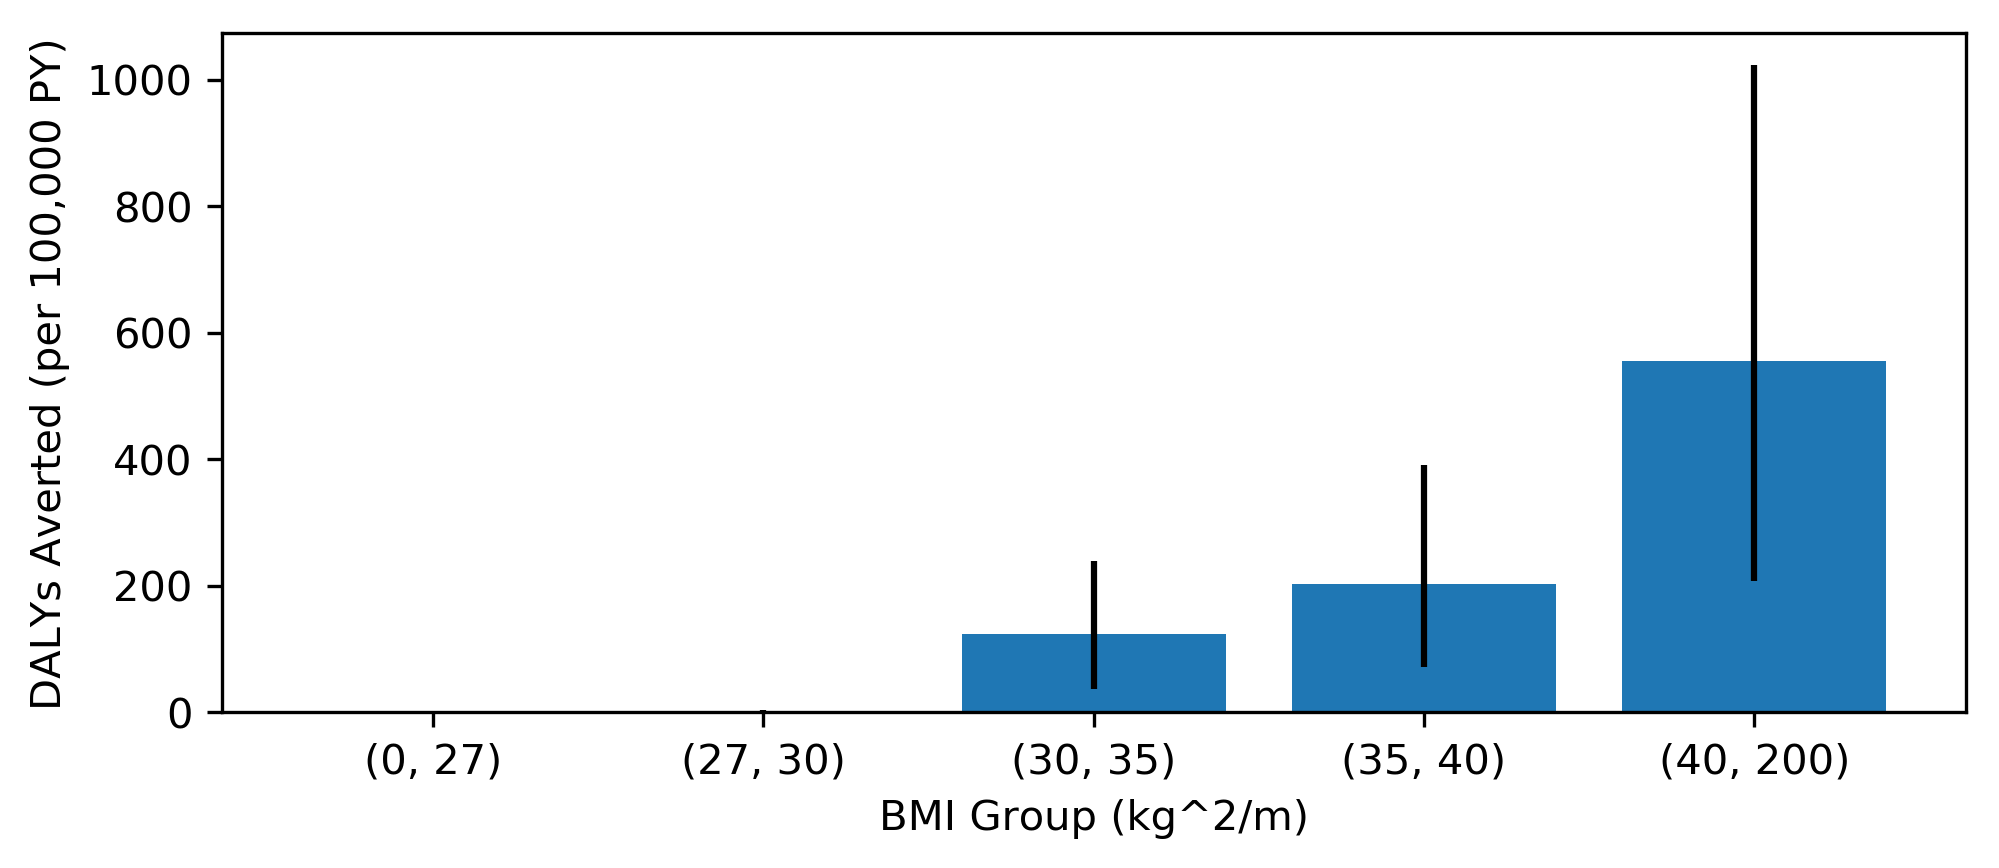

In [62]:
plt.figure(figsize=(7.5, 3), dpi=300)
xx = t.index.get_level_values(3)
yy = t.averted_mean
ll = yy - t['averted_2.5%']
uu = t['averted_97.5%'] - yy

plt.bar(xx, yy, yerr=[ll, uu])
plt.xlabel('BMI Group (kg^2/m)')
plt.ylabel('DALYs Averted (per 100,000 PY)');